In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Access dataset on google drive
dataset_fld = '/content/drive/MyDrive/Colab Notebooks/TESS Toronto emotional speech set data'

In [ ]:
# Import os library for file management
# Setting up the path to the dataset folder in Google Drive
import os
files = os.listdir(dataset_fld)
print("Files in dataset folder:", files)

Files in dataset folder: ['YAF_sad', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_angry', 'OAF_Pleasant_surprise', 'OAF_Sad', 'YAF_disgust', 'TESS Toronto emotional speech set data', 'YAF_fear', 'YAF_happy', 'OAF_happy', 'OAF_disgust', 'OAF_angry', 'OAF_neutral', 'OAF_Fear']


In [ ]:
# Import important libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
paths = []
labels = []
# Setting up the path to the dataset folder in Google Drive
# Ensuring the path is correctly pointed to the location where the dataset is stored.
for dirname, _, filenames in os.walk(dataset_fld):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

In [ ]:
# Confirm if dataset is loaded
print(f"Dataset is Loaded. {len(paths)} files loaded.")

Dataset is Loaded. 2800 files loaded.


### EXPLORATORY DATA ANALYSIS

In [ ]:
df = pd.DataFrame({
    'file_path': paths,
    'label': labels
})

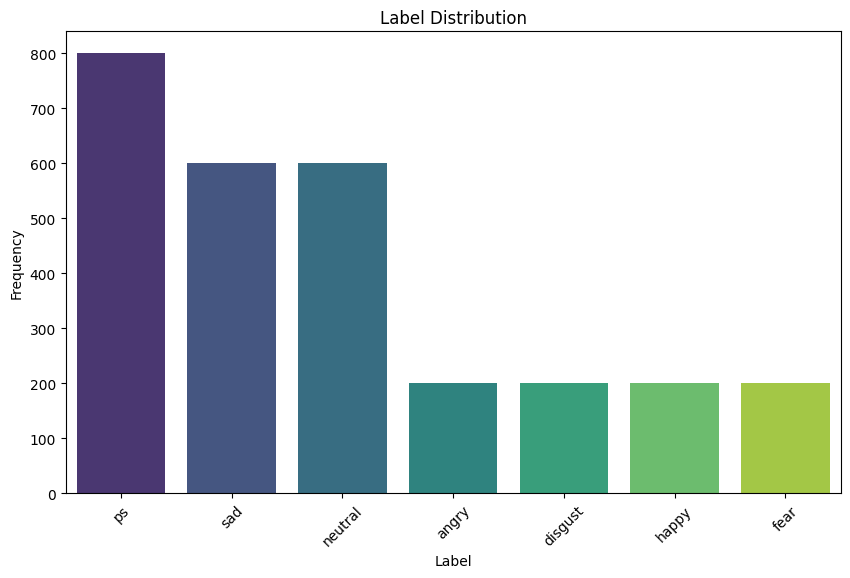

In [ ]:
# Analyze the class distribution for labels
# Count the occurrences of each label in the 'label' column
label_counts = df['label'].value_counts()

# Set up the figure for the bar plot
# Define the size of the figure for better visibility
plt.figure(figsize=(10, 6))

# Create a bar plot of the label distribution using seaborn
# Plot labels on the x-axis and their corresponding frequencies on the y-axis
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Customize the plot for better readability
plt.title('Label Distribution')

# Label the x-axis and y-axis accordingly
plt.xlabel('Label')
plt.ylabel('Frequency')

# Rotate the x-axis labels slightly for better alignment
plt.xticks(rotation=45)

# Display the final plot
plt.show()


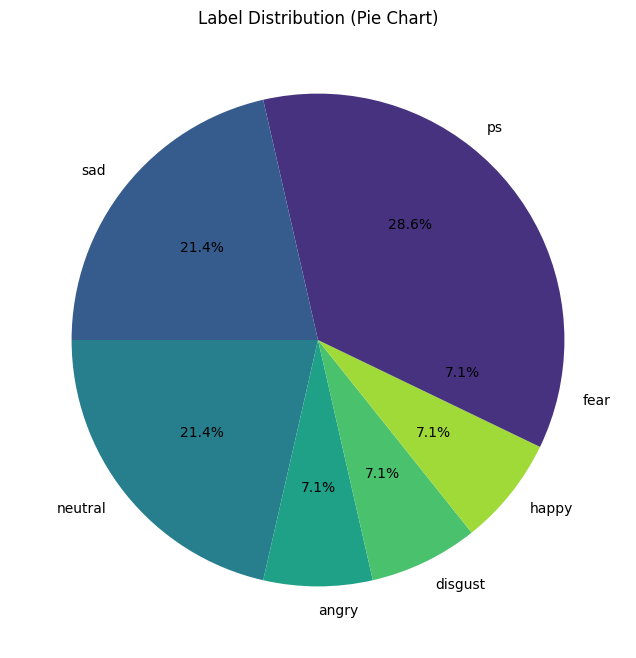

In [ ]:
# Visualize the label distribution using a pie chart
# Pie charts can be useful for understanding the proportion of each label

# Create a pie chart of label distribution
# 'autopct' argument adds percentage labels to each slice of the pie
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'))

# Add a title for clarity
plt.title('Label Distribution (Pie Chart)')

# Display the pie chart
plt.show()


In [ ]:
# Analyze the duration of each audio file

# Initialize an empty list to store the duration of each file
durations = []

# Loop through each file path in the 'file_path' column of the dataframe
for file in df['file_path']:

    # Load the audio file using Librosa
    y, sr = librosa.load(file)

    # Calculate the duration of the audio file
    duration = librosa.get_duration(y=y, sr=sr)

    # Append the calculated duration to the list
    durations.append(duration)


In [ ]:
df['duration'] = durations

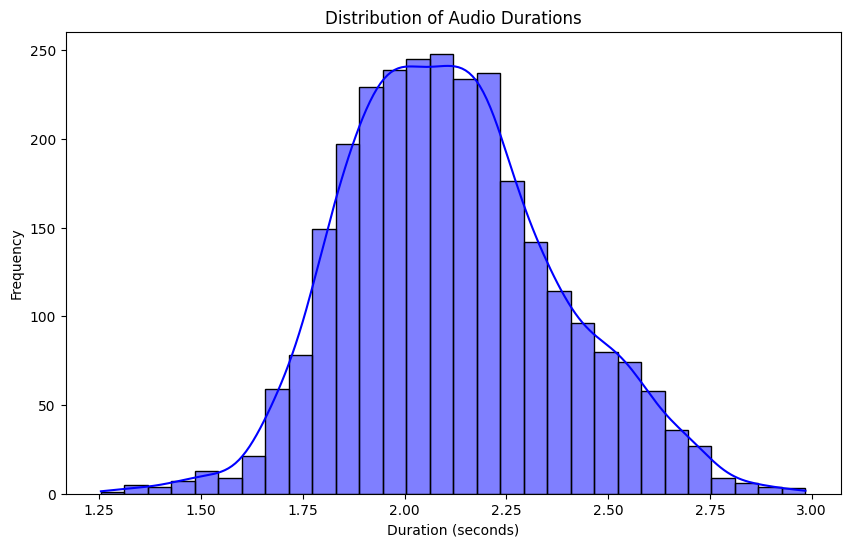

In [ ]:
# Set up the figure size for the histogram
plt.figure(figsize=(10, 6))

# Plot the distribution of audio durations with a kernel density estimate (KDE)
sns.histplot(df['duration'], kde=True, bins=30, color='blue')

# Add title and axis labels for clarity
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [ ]:
# Feature extraction: Extract MFCCs (Mel-Frequency Cepstral Coefficients) from each audio file
mfccs_list = []

# Loop through each file in the 'file_path' column
for file in df['file_path']:

    # Load the audio file using Librosa
    y, sr = librosa.load(file)

    # Extract the MFCC features from the audio signal
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    # Append the mean of the MFCC features across time to the list
    mfccs_list.append(mfcc.mean(axis=1))


In [ ]:
# Assign the list of mean MFCCs to a new column in the DataFrame
df['mfcc_mean'] = mfccs_list


In [ ]:
# Generate descriptive statistics for the 'duration' and 'mfcc_mean' columns
df[['duration', 'mfcc_mean']].describe()


,duration
count,2800.000000
mean,2.114468
std,0.259071
min,1.254104
25%,1.928345
50%,2.097982
75%,2.274796
max,2.984807


### CONTENT-BASED FILTERING RECOMMENDATION SYSTEM

In [ ]:
# Import the TfidfVectorizer for converting a collection of text documents to a matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

# Import cosine_similarity to compute the cosine similarity between two or more sets of vectors
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Retrieve the column names of the DataFrame
df.columns

Index(['file_path', 'label', 'duration', 'mfcc_mean'], dtype='object')

In [ ]:
# Stack the mean MFCCs from the DataFrame into a 2D NumPy array
mfcc_matrix = np.stack(df['mfcc_mean'].values)

In [ ]:
# Compute the cosine similarity matrix for the MFCC feature matrix
cosine_sim = cosine_similarity(mfcc_matrix, mfcc_matrix)


In [ ]:
# Define a function to get recommendations based on MFCC similarity
def get_recommendations_mfcc(speech_index, cosine_sim=cosine_sim, k=5):

    # Get the similarity scores for the specified speech index
    sim_scores = list(enumerate(cosine_sim[speech_index]))

    # Sort the scores in descending order based on similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select the top k most similar speeches, excluding the first one (itself)
    sim_scores = sim_scores[1:k + 1]

    # Extract the indices of the top k similar speeches
    speech_indices = [i[0] for i in sim_scores]

    # Return the DataFrame rows corresponding to the top k similar speeches
    return df.iloc[speech_indices]


In [ ]:
# Get recommendations for the speech at index 0, retrieving the top 3 similar speeches
recommended_speeches = get_recommendations_mfcc(0, k=3)

# Print the file path, label, and duration of the recommended speeches
print(recommended_speeches[['file_path', 'label', 'duration']])


                                              file_path label  duration
1801  /content/drive/MyDrive/Colab Notebooks/TESS To...   sad  2.297415
1     /content/drive/MyDrive/Colab Notebooks/TESS To...   sad  2.144717
1800  /content/drive/MyDrive/Colab Notebooks/TESS To...   sad  2.144717


In [ ]:
# Retrieve the unique labels from the 'label' column of the DataFrame
df['label'].unique()


array(['sad', 'neutral', 'ps', 'angry', 'disgust', 'happy', 'fear'],
      dtype=object)

In [ ]:
# Count the occurrences of the label 'fear (1)' in the DataFrame
fear_1 = df['label'].value_counts().get('fear (1)', 0)

# Print the number of occurrences of the 'fear (1)' label
print(f"Number of 'fear (1)' labels: {fear_1}")

Number of 'fear (1)' labels: 0


In [ ]:
# replace 'fear (1)' to 'fear'

df['label'] = df['label'].replace({'fear (1)': 'fear'})
print(df['label'].unique())

['sad' 'neutral' 'ps' 'angry' 'disgust' 'happy' 'fear']


### MODEL EVALUATION BASED ON MFCC FEATURES

In [ ]:
# Define the true labels for model evaluation based on MFCC features
true_labels = ['sad', 'angry', 'fear', 'happy', 'neutral', 'disgust', 'ps']


In [ ]:
# Define a function to evaluate recommendations based on precision and recall
def evaluate_recommendations(df, true_labels, k=3):
    precisions = []  # List to store precision values
    recalls = []     # List to store recall values
    true_labels = df['label'].tolist()  # Convert true labels to a list

    # Loop through each true label and its index
    for i, true in enumerate(true_labels):
        # Get the recommended labels for the current speech index
        recommended_labels = get_recommendations_mfcc(i, k=k)['label'].tolist()

        # Debug: Print true labels and recommended labels for each instance
        print(f"Index {i}: True Labels: {true} | Recommended Labels: {recommended_labels}")

        # Identify relevant and retrieved labels as sets
        relevant = set(true)
        retrieved = set(recommended_labels[:k])

        # Calculate precision: the proportion of relevant labels among retrieved labels
        precision = len(relevant & retrieved) / len(retrieved) if retrieved else 0

        # Calculate recall: the proportion of relevant labels that were retrieved
        recall = len(relevant & retrieved) / len(relevant) if relevant else 0

        # Append calculated precision and recall to their respective lists
        precisions.append(precision)
        recalls.append(recall)

    # Calculate average precision and recall across all evaluated instances
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0

    # Return the average precision and recall
    return avg_precision, avg_recall


In [ ]:
# Evaluate the recommendations with debug information
avg_precision, avg_recall = evaluate_recommendations(df, true_labels, k=3)
print(f"Average Precision@3: {avg_precision}")
print(f"Average Recall@3: {avg_recall}")


Index 0: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 1: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 2: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 3: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 4: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 5: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 6: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 7: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 8: True Labels: sad | Recommended Labels: ['sad', 'neutral', 'neutral']
Index 9: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 10: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 11: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 12: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 13: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 14

In [ ]:
# Define a function for grid search evaluation of hybrid similarity
def grid_search_evaluation(df, k=5):
    # Generate a range of alpha values from 0 to 1, with 11 evenly spaced points
    alphas = np.linspace(0, 1, 11)
    betas = 1 - alphas  # Calculate corresponding beta values

    # Initialize variables to track the best parameters and their performance
    best_alpha, best_beta = 0, 0
    best_precision, best_recall = 0, 0

    # Iterate over each pair of alpha and beta values
    for alpha, beta in zip(alphas, betas):
        # Compute hybrid similarity by combining MFCC and label similarities
        hybrid_sim = (alpha * cosine_sim_mfcc) + (beta * label_sim)

        # Evaluate recommendations based on the hybrid similarity
        avg_precision, avg_recall = evaluate_recommendations(df, hybrid_sim, k)

        # Print the current alpha, beta, precision, and recall
        print(f"Alpha: {alpha}, Beta: {beta}, Precision@{k}: {avg_precision}, Recall@{k}: {avg_recall}")

        # Update the best parameters if the current precision is better
        if avg_precision > best_precision:
            best_alpha, best_beta = alpha, beta
            best_precision, best_recall = avg_precision, avg_recall


In [ ]:
# Evaluate the recommendations and calculate average precision and recall with k=3
avg_precision, avg_recall = evaluate_recommendations(df, true_labels, k=3)

# Print the average precision at k=3
print(f"Average Precision@3: {avg_precision}")

# Print the average recall at k=3
print(f"Average Recall@3: {avg_recall}")


Index 0: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 1: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 2: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 3: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 4: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 5: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 6: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 7: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 8: True Labels: sad | Recommended Labels: ['sad', 'neutral', 'neutral']
Index 9: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 10: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 11: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 12: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 13: True Labels: sad | Recommended Labels: ['sad', 'sad', 'sad']
Index 14

### HYBRID RECOMMENDATION SYSTEM

In [ ]:
# Stack the mean MFCCs from the DataFrame into a 2D NumPy array
mfcc_matrix = np.stack(df['mfcc_mean'].values)

# Compute the cosine similarity matrix for the MFCC feature matrix
cosine_sim_mfcc = cosine_similarity(mfcc_matrix, mfcc_matrix)


In [ ]:
# Define a function to create a label similarity matrix based on the labels in the DataFrame
def label_similarity_matrix(df):
    # Extract labels from the DataFrame
    labels = df['label'].values

    # Initialize a square matrix to hold label similarities
    label_sim = np.zeros((len(labels), len(labels)))

    # Loop through each pair of labels to populate the similarity matrix
    for i in range(len(labels)):
        for j in range(len(labels)):
            # Set similarity to 1 if labels are the same, otherwise 0
            label_sim[i][j] = 1 if labels[i] == labels[j] else 0

    # Return the completed label similarity matrix
    return label_sim


In [ ]:
# Generate the label similarity matrix based on the labels in the DataFrame
label_sim = label_similarity_matrix(df)

In [ ]:
# Set the weight for the MFCC similarity
alpha = 0.7

# Set the weight for the label similarity
beta = 0.3


In [ ]:
# Calculate the hybrid similarity by combining MFCC and label similarities using the specified weights
hybrid_sim = (alpha * cosine_sim_mfcc) + (beta * label_sim)


In [ ]:
# Define a function to get hybrid recommendations based on the hybrid similarity matrix
def get_hybrid_recommendations(speech_index, hybrid_sim=hybrid_sim, k=5):
    # Get the similarity scores for the specified speech index
    sim_scores = list(enumerate(hybrid_sim[speech_index]))

    # Sort the scores in descending order based on similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select the top k most similar speeches, excluding the first one (itself)
    sim_scores = sim_scores[1:k + 1]

    # Extract the indices of the top k similar speeches
    speech_indices = [i[0] for i in sim_scores]

    # Return the DataFrame rows corresponding to the top k similar speeches
    return df.iloc[speech_indices]


In [ ]:
# Get recommendations for the speech at index 0, retrieving the top 3 similar speeches based on hybrid similarity
recommended_speeches = get_hybrid_recommendations(0, k=3)

# Print the file path, label, and duration of the recommended speeches
print(recommended_speeches[['file_path', 'label', 'duration']])


                                              file_path label  duration
1801  /content/drive/MyDrive/Colab Notebooks/TESS To...   sad  2.297415
1     /content/drive/MyDrive/Colab Notebooks/TESS To...   sad  2.144717
1800  /content/drive/MyDrive/Colab Notebooks/TESS To...   sad  2.144717


### WEIGHT COMBINATIONS

In [ ]:
# Define a function for grid search evaluation of hybrid similarity
def grid_search_evaluation(df, k=5):
    # Generate a range of alpha values from 0 to 1, with 11 evenly spaced points
    alphas = np.linspace(0, 1, 11)
    betas = 1 - alphas  # Calculate corresponding beta values

    # Initialize variables to track the best parameters and their performance
    best_alpha, best_beta = 0, 0
    best_precision, best_recall = 0, 0

    # Iterate over each pair of alpha and beta values
    for alpha, beta in zip(alphas, betas):
        # Compute hybrid similarity by combining MFCC and label similarities
        hybrid_sim = (alpha * cosine_sim_mfcc) + (beta * label_sim)

        # Evaluate recommendations based on the hybrid similarity
        avg_precision, avg_recall = evaluate_recommendations(df, hybrid_sim, k)

        # Print the current alpha, beta, precision, and recall
        print(f"Alpha: {alpha}, Beta: {beta}, Precision@{k}: {avg_precision}, Recall@{k}: {avg_recall}")

        # Update the best parameters if the current precision is better
        if avg_precision > best_precision:
            best_alpha, best_beta = alpha, beta
            best_precision, best_recall = avg_precision, avg_recall

    # Print the best alpha and beta values along with their corresponding precision and recall
    print(f"Best alpha: {best_alpha}, Best beta: {best_beta}")
    print(f"Best Precision@{k}: {best_precision}, Best Recall@{k}: {best_recall}")


In [ ]:
# Define a function to evaluate recommendations based on a similarity matrix
def evaluate_recommendations(df, sim_matrix, k):
    # Initialize lists to store precision and recall values
    precisions = []
    recalls = []

    # Iterate through each entry in the DataFrame
    for i in range(len(df)):
        true_label = df.iloc[i]['label']  # Get the true label for the current entry

        # Get similarity scores for the current entry and sort them
        sim_scores = list(enumerate(sim_matrix[i]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Select the top k similar entries, excluding the first (itself)
        sim_scores = sim_scores[1:k + 1]

        # Extract recommended labels based on the sorted similarity scores
        recommended_labels = [df.iloc[j[0]]['label'] for j in sim_scores]

        # Calculate the number of relevant recommended labels
        relevant = recommended_labels.count(true_label)

        # Calculate precision: the proportion of relevant labels among the top k recommendations
        precision = relevant / k

        # Calculate total relevant occurrences of the true label in the DataFrame
        total_relevant = df['label'].tolist().count(true_label)

        # Calculate recall: the proportion of relevant labels retrieved from the total relevant
        recall = relevant / total_relevant if total_relevant > 0 else 0

        # Append calculated precision and recall to their respective lists
        precisions.append(precision)
        recalls.append(recall)

    # Calculate average precision and recall across all evaluated entries
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    # Return the average precision and recall
    return avg_precision, avg_recall


In [ ]:
# Define a function for grid search evaluation of hybrid similarity with cosine and label similarities
def grid_search_evaluation(df, cosine_sim_mfcc, label_sim, k=5):
    # Generate a range of alpha values from 0 to 1, with 11 evenly spaced points
    alphas = np.linspace(0, 1, 11)
    betas = 1 - alphas  # Calculate corresponding beta values

    # Initialize variables to track the best parameters and their performance
    best_alpha, best_beta = 0, 0
    best_precision, best_recall = 0, 0

    # Iterate over each pair of alpha and beta values
    for alpha, beta in zip(alphas, betas):
        # Compute hybrid similarity by combining MFCC and label similarities
        hybrid_sim = (alpha * cosine_sim_mfcc) + (beta * label_sim)

        # Evaluate recommendations based on the hybrid similarity
        avg_precision, avg_recall = evaluate_recommendations(df, hybrid_sim, k)

        # Print the current alpha, beta, precision, and recall
        print(f"Alpha: {alpha}, Beta: {beta}, Precision@{k}: {avg_precision}, Recall@{k}: {avg_recall}")

        # Update the best parameters if the current precision is better
        if avg_precision > best_precision:
            best_alpha, best_beta = alpha, beta
            best_precision, best_recall = avg_precision, avg_recall

    # Print the best alpha and beta values along with their corresponding precision and recall
    print(f"Best alpha: {best_alpha}, Best beta: {best_beta}")
    print(f"Best Precision@{k}: {best_precision}, Best Recall@{k}: {best_recall}")

    # Return the best alpha, beta, precision, and recall values
    return best_alpha, best_beta, best_precision, best_recall


In [ ]:
# Generate a random cosine similarity matrix for MFCC features
cosine_sim_mfcc = np.random.rand(len(df), len(df))

# Generate a random label similarity matrix
label_sim = np.random.rand(len(df), len(df))

# Perform grid search evaluation to find the best alpha, beta, precision, and recall values
best_alpha, best_beta, best_precision, best_recall = grid_search_evaluation(df, cosine_sim_mfcc, label_sim, k=5)


Alpha: 0.1, Beta: 0.9, Precision@5: 0.1950714285714286, Recall@5: 0.0018180059523809525
Alpha: 0.2, Beta: 0.8, Precision@5: 0.19300000000000003, Recall@5: 0.001799404761904762
Alpha: 0.30000000000000004, Beta: 0.7, Precision@5: 0.18992857142857142, Recall@5: 0.0017691964285714288
Alpha: 0.4, Beta: 0.6, Precision@5: 0.19007142857142859, Recall@5: 0.0017566964285714286
Alpha: 0.5, Beta: 0.5, Precision@5: 0.19364285714285717, Recall@5: 0.0018190476190476192
Alpha: 0.6000000000000001, Beta: 0.3999999999999999, Precision@5: 0.1958571428571429, Recall@5: 0.001830952380952381
Alpha: 0.7000000000000001, Beta: 0.29999999999999993, Precision@5: 0.1987857142857143, Recall@5: 0.0018629464285714287
Alpha: 0.8, Beta: 0.19999999999999996, Precision@5: 0.19585714285714284, Recall@5: 0.001827529761904762
Alpha: 0.9, Beta: 0.09999999999999998, Precision@5: 0.19678571428571429, Recall@5: 0.0018666666666666666
Alpha: 1.0, Beta: 0.0, Precision@5: 0.1975, Recall@5: 0.0018422619047619047
Best alpha: 0.700000